## Installations


In [2]:
#!pip install polars
#!pip install pyts
#!pip install sweetviz
#!pip install PyRQA
#!pip install pyopencl

## Imports


In [3]:
import pandas as pd
import numpy as np
import polars as pl
import polars.selectors as cs
import matplotlib.pyplot as plt
import math
import sweetviz as sv
import os, time
from tempfile import TemporaryDirectory
import pyopencl as cl
from pyrqa.opencl import OpenCL
import csv

# from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from pyts.image import RecurrencePlot
from pyrqa.settings import Settings
from pyrqa.neighbourhood import FixedRadius
from pyrqa.neighbourhood import FAN
from pyrqa.metric import EuclideanMetric
from pyrqa.computation import RQAComputation
from pyrqa.computation import RPComputation
from pyrqa.image_generator import ImageGenerator
from pyrqa.analysis_type import Classic
from pyrqa.time_series import TimeSeries

# Imports
import torch
import torch.nn as nn  # All neural network modules, nn.Linear, nn.Conv2d, BatchNorm, Loss functions
import torch.optim as optim  # For all Optimization algorithms, SGD, Adam, etc.
from torchvision.transforms import v2  # Transformations we can perform on our dataset
import torchvision
from torchvision.io import read_image
import os
from tqdm import tqdm
import torchinfo
from torch.utils.data import Dataset, DataLoader

## Settings


In [4]:
#pl.Config.set_streaming_chunk_size(5000)

#platform = cl.get_platforms()
#platform[0].get_devices(1)

opencl = OpenCL(platform_id=0,
                device_ids=(0,))

## Function Declarations


In [5]:
'Pandas Functions'

def check_conversion(dataframe: pd.DataFrame) -> bool:

    """
    Checking to see if conversion was successful, returning 0 na's.
    """
    
    if dataframe['Value'].isna().sum() == 0:
        return True


def pivot(dataframe: pd.DataFrame) -> pd.DataFrame:
    
    """
    Pivot dataframe to long format.
    """
    
    dataframe = dataframe.pivot_table(index = 'TimeStamp', columns = 'Name', values = 'Value')
                                    
    return dataframe


def resample_df(dataframe: pd.DataFrame) -> pd.DataFrame:
    
    """
    Resample dataframe with basic interpolation of missing values
    """
    
    
    dataframe.reset_index(inplace = True)
    dataframe['TimeStamp'] = pd.to_datetime(dataframe['TimeStamp'])
    dataframe.set_index('TimeStamp', inplace = True)
    
    for column in dataframe.columns:
        dataframe[column] = dataframe[column].ffill()
        dataframe[column] = dataframe[column].bfill()
    
    dataframe = dataframe.resample('5s').first()
    dataframe.dropna(how = 'all', inplace = True)
            
    return dataframe


'*********************************************'

'Polars Functions - ideal to use as polars is much more performant than pandas.'


def check_conversion_pl(dataframe: pl.DataFrame) -> bool:

    """
    Checking to see if conversion was successful, returning 0 na's.
    """
    
    if dataframe.select(pl.sum('Value')).null_count().collect().item() == 0:
    
        return True


def pivot_pl(dataframe: pl.DataFrame) -> pl.DataFrame:
    
    """
    Pivot dataframe to long format.
    """
    
    result = dataframe.collect().pivot(index = 'TimeStamp', columns = 'Name', values = 'Value',
                                                    aggregate_function = 'first')
    
    return result.lazy()


def resample_pl(dataframe: pl.DataFrame) -> pl.DataFrame:

    """
    Resample dataframe with basic interpolation of missing values
    """
    
    dataframe = dataframe.select(pl.all().forward_fill())
    dataframe = dataframe.select(pl.all().backward_fill())
    
    dataframe = dataframe.sort(by = 'TimeStamp').group_by_dynamic(index_column = 'TimeStamp', 
                                                                  every='5s',
                                                                  check_sorted = False).agg(pl.exclude('TimeStamp').first())
                            
    return dataframe.lazy()


def save_rqa_features(result_obj, dataframe: pl.DataFrame) -> pl.DataFrame:
    
    """
    Add results from RQA to dataframe for future analysis.
    """
    
    #retrieve new data
    data = result_obj.to_array()
    data = np.reshape(data, (1, data.shape[0]))

    #create new dataframe
    new_df = pl.DataFrame(data=data,
                              schema = {
                                  'MDL',
                                  'MVL',
                                  'MWVL',
                                  'RR',
                                  'DET',
                                  'ADL',
                                  'LDL',
                                  'DIV',
                                  'EDL',
                                  'LAM',
                                  'TT',
                                  'LVL',
                                  'EVL',
                                  'AWVL',
                                  'LWVL',
                                  'LWVLI',
                                  'EWVL',
                                  'Ratio_DRR',
                                  'Ratio_LD'
                                  },
                                  orient='row'
                            )

    #append new dataframe to results
    dataframe = dataframe.concat(new_df).lazy()

    return dataframe

'*********************************************'

'Reccurence Plot Functions'


def reshape_input(dataframe: pl.DataFrame) -> np.array:
    
    """
    Convert dataframe to array and reshape.
    """
    
    result = dataframe.collect().to_numpy()
    result = np.swapaxes(result, 0, 1)
    
    return result


def scale_input(a: np.array) -> np.array:
    
    """
    Scale input array with standard scaler.
    """
    
    #scaler = MinMaxScaler()
    scaler = StandardScaler()
    result = scaler.fit_transform(a)
    
    return result


def plot_reccurence(input_array, stride, iteration, dates, data_idx, target):

    """
    Generates reccurance plots and RQA matrix for input array.
    
    Slices input array based on user specified parameter stide.

    Saves plots and RQA matrix for further analysis, as well as a mpaaing file of plots to data index, sensor names, and date range of the sensor for future reference.
    
    """

    splits = math.floor(input_array.shape[1]/stride) #generate number of splits
    array_list = np.array_split(input_array, splits, axis = 1) #split array

    first = True
    rqa_df = None
    columns = ["MDL","MVL","MWVL","RR","DET","ADL","LDL","DIV","EDL","LAM","TT","LVL","EVL","AWVL", "LWVL","LWVLI","EWVL","Ratio_DRR","Ratio_LD"]
    start_date_idx = 0
    end_date_idx = 0

    if target == 'normal':
        direct = 'Train-Healthy'
        label = 0
    if target == 'abnormal':
        direct = 'Train-Unhealthy'
        label = 1

    for i, a in enumerate(array_list): #for each array in arraylist
        for j, _ in enumerate(a):

            # Generate RQA Matrix
            ts = TimeSeries(a[j],
                    embedding_dimension=3,
                    time_delay=1)

            rp = Settings(ts,
                    analysis_type=Classic,
                    neighbourhood=FixedRadius(.05),
                    similarity_measure=EuclideanMetric,
                    theiler_corrector=1)

            computation = RQAComputation.create(rp, opencl = opencl, verbose = False)

            result = computation.run()

            result.min_diagonal_line_length=2
            result.min_vertical_line_length=2
            result.min_white_vertical_line_length=2

            # add results from run to df
            if first == True:
                result = result.to_array()
                result = np.reshape(result, (1, result.shape[0])) 
                rqa_df = pl.DataFrame(data=result, schema = columns, orient='row').lazy()

            else:
                result = result.to_array()
                result = np.reshape(result, (1, result.shape[0]))
                new_results = pl.DataFrame(data=result, schema=columns, orient="row").lazy()
                rqa_df = pl.concat([rqa_df, new_results]).lazy()

            # generate RP
            computation = RPComputation.create(rp, opencl = opencl, verbose = False) 
            result = computation.run()
            ImageGenerator.save_recurrence_plot(
                result.recurrence_matrix_reverse,
                f"../RP/{direct}/Iteration_{iteration}_Split_{i}_Sensor_{j}_{target}.png",
            )

            # get start and end date of array for this split
            end_date_idx = start_date_idx + a.shape[1]
            start_date = dates.slice(start_date_idx,1).collect().item()
            end_date = dates.slice(end_date_idx-1,1).collect().item()

            # save rp filenames with time window, sensor name, and label (in this case, 0 = normal)
            with open(f'../RP/{direct}/mapping.csv', 'a') as fileobj:
                fileobj.write(f"{data_idx},Iteration_{iteration}_Split_{i}_Sensor_{j}_{target}.png,{start_date},{end_date},{label}\n")
                data_idx += 1

            # set flag to false for df generation
            first = False

        start_date_idx = end_date_idx

    return rqa_df, data_idx

## Data Processing

The goal here is to read in slices of data from the normal set, and create a series of images to be used in our analysis.


In [5]:
raw_df = pl.scan_parquet(
    "../Data/conditionmeasurements_0277_no_breakdown.parquet/*.parquet", n_rows=18000000
)

raw_df_unhealthy = pl.scan_parquet(
    "../Data/conditionnmeasurements_0277_20230104_20230107.parquet/*.parquet", n_rows = 1000000
)

In [6]:
#raw_df.collect().shape - (18,000,000, 3)
#raw_df_unhealthy.collect().shape - (1,070,285, 3)

## Creation of training dataset

### Healthy Samples

In [7]:
n_rows = 1000000  # number rows to slice - 18 slices
start = 0
stride = 200 # ideal window parameter - not exact as depends on input array shape. More of a suggestion


# loop through parquet
data_idx = 0
final_RP_df = None
first = True

for i in range(2):

    curr_df = raw_df.slice(offset=start, length=n_rows)
    start += n_rows

    # run dataframe through pre-processing pipeline

    try:
        check_conversion_pl(curr_df)
    except:
        raise ValueError("Dataframe contains null values")

    # pivot
    df = pivot_pl(curr_df)

    # resample
    df = resample_pl(df)

    # drop columns
    df = df.drop(
        ~cs.contains(
            ("Temperature", "Pressure", "Engine", "Transmission", "Speed", "Time")
        )
    )
    df = df.drop(
        cs.contains(
            (
                "Total",
                "Transmission Hours",
                "Ambient",
                "Engine Hours",
                "Tire Pressure",
                "Catalyst",
                "Engine Running",
                "Transmission Retarder Active",
                "Instant Fuel",
                "DPF Pressure",
                "DPF Temperature",
                "Upbox Oil Temperature",
            )
        )
    ).unique(maintain_order=True)

    # save dates of iteration for future use
    dates = df.select(cs.datetime())

    # convert to numpy and reshape
    array = reshape_input(df.select(~cs.datetime()))

    # scale input
    array = scale_input(array)

    # generate recurrence plot
    if first == True:
        final_RP_df, data_idx = plot_reccurence(array, stride, i, dates, data_idx, target="normal")
        first = False
    else:
        intermediate_RP_df, data_idx = plot_reccurence(array, stride, i, dates, data_idx, target = 'normal')
        final_RP_df = pl.concat([final_RP_df, intermediate_RP_df]).lazy()

### Unhealthy Samples

In [10]:
n_rows = 1000000  # number rows to slice
start = 0
stride = 200  # ideal window parameter - not exact as depends on input array shape. More of a suggestion

data_idx = 0
final_RP_df_abnormal = None
first = True

# loop through parquet
for i in range(1):

    curr_df = raw_df_unhealthy.slice(offset=start, length=n_rows)
    start += n_rows

    # run dataframe through pre-processing pipeline

    try:
        check_conversion_pl(curr_df)
    except:
        raise ValueError("Dataframe contains null values")

    # pivot
    df = pivot_pl(curr_df)

    # resample
    df = resample_pl(df)

    # drop columns
    df = df.drop(
        ~cs.contains(
            ("Temperature", "Pressure", "Engine", "Transmission", "Speed", "Time")
        )
    )
    df = df.drop(
        cs.contains(
            (
                "Total",
                "Transmission Hours",
                "Ambient",
                "Engine Hours",
                "Tire Pressure",
                "Catalyst",
                "Engine Running",
                "Transmission Retarder Active",
                "Instant Fuel",
                "DPF Pressure",
                "DPF Temperature",
                "Upbox Oil Temperature",
            )
        )
    ).unique(maintain_order=True)

    # save dates of iteration for future use
    dates = df.select(cs.datetime())

    # convert to numpy and reshape
    array = reshape_input(df.select(~cs.datetime()))

    # scale input
    array = scale_input(array)

    # generate recurrence plot
    if first == True:
        final_RP_df_abnormal, data_idx = plot_reccurence(array, stride, i, dates, data_idx, target="abnormal")
        first = False
    else:
        intermediate_RP_df, data_idx = plot_reccurence(array, stride, i, dates, data_idx,target="abnormal")
        final_RP_df_abnormal = pl.concat([final_RP_df_abnormal, intermediate_RP_df]).lazy()

In [16]:
final_RP_df.collect().write_csv("../Data/healthy_rp.csv")
final_RP_df_abnormal.collect().write_csv("../Data/unhealthy_rp.csv")

### Feature Extraction with GoogLeNet

In [6]:
# create the dataset class

class rp_dataset(Dataset):

    def __init__(self, mapping, data_dir, transform = None):
        self.data = data_dir #directory for training data
        self.mapping = pd.read_csv(mapping, header = None, index_col=0) #file for rp plot names
        self.transform = transform #transformations

    def __len__(self):
        return len(self.mapping)

    def __getitem__(self, idx):
        rp_path = os.path.join(self.data, self.mapping.iloc[idx,0]) #create path to plot
        rp = read_image(rp_path)
        y_label = torch.tensor(int(self.mapping.iloc[idx, 3]))
        
        if self.transform:
            rp = self.transform(rp)
        
        return rp, y_label

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
transform = v2.Compose(
    [
        v2.Resize(224), #expects input size of 224x224 minimum
        v2.ToDtype(torch.float32, scale=True), #transform to float to be clipped between 0-1
        v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), #normalisation values in googlenet paper
    ]
)

In [9]:
training_healthy_data_dir = '../RP/Train-Healthy'
mapping = '../RP/Train-Healthy/mapping.csv'

# healthy

training_healthy = rp_dataset(mapping, training_healthy_data_dir, transform=transform)
training_healthy_dataloader = DataLoader(training_healthy, 64, shuffle=False, pin_memory=True
)


training_unhealthy_data_dir = "../RP/Train-Unhealthy"
mapping = "../RP/Train-Unhealthy/mapping.csv"

# unhealthy
training_unhealthy = rp_dataset(mapping, training_unhealthy_data_dir, transform=transform)
training_unhealthy_dataloader = DataLoader(training_unhealthy, 64, shuffle=False, pin_memory=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Feature batch shape: torch.Size([64, 3, 224, 224])
Feature label shape: torch.Size([64])


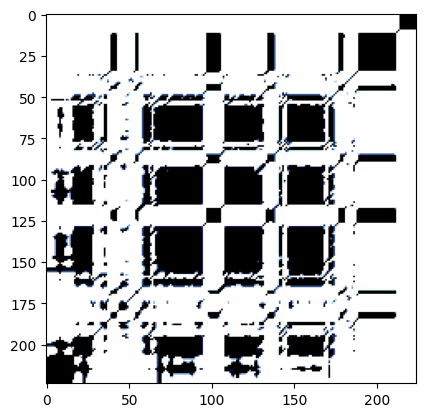

In [10]:
# example healthy for googlenet

train_healthy_features, train_healthy_labels = next(iter(training_healthy_dataloader))
print(f"Feature batch shape: {train_healthy_features.size()}")
print(f"Feature label shape: {train_healthy_labels.size()}")
img = train_healthy_features[0].squeeze()
label = train_healthy_labels[0]
img = img.swapaxes(0,1)
img = img.swapaxes(1,2)
plt.imshow(img, cmap="gray")
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Feature batch shape: torch.Size([64, 3, 224, 224])
Feature label shape: torch.Size([64])


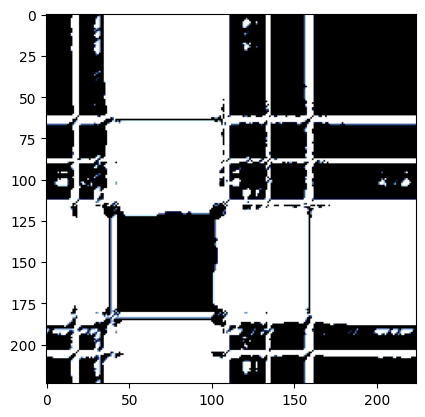

In [11]:
# example unhealthy for googlenet

train_unhealthy_features, train_unhealthy_labels = next(iter(training_unhealthy_dataloader))
print(f"Feature batch shape: {train_unhealthy_features.size()}")
print(f"Feature label shape: {train_unhealthy_labels.size()}")
img = train_unhealthy_features[0].squeeze()
label = train_unhealthy_labels[0]
img = img.swapaxes(0, 1)
img = img.swapaxes(1, 2)
plt.imshow(img, cmap="gray")
plt.show()

### Feature Extraction on Pretrained Network

In [12]:
model = torchvision.models.googlenet(weights="GoogLeNet_Weights.DEFAULT")

class GoogLeNet(nn.Module):
    def __init__(self):
        super(GoogLeNet, self).__init__()
        self.features = nn.Sequential(
            *list(model.children())[:-1]
            )
        
    def forward(self, x):
        x = self.features(x)
        return x

In [13]:
def feature_extraction(dataloader, model):
    model.eval()

    results = None

    with torch.no_grad():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            out = model(X)
            if results is None:
                results = np.asarray(torch.Tensor.cpu(out))
            else:
                results = np.append(results, np.asarray(torch.Tensor.cpu(out)), axis = 0)

    return results.squeeze()

In [14]:
model = GoogLeNet()
model.to(device)

healthy_googlenet_features_pretrained = feature_extraction(training_healthy_dataloader, model=model)
unhealthy_googlenet_features_pretrained = feature_extraction(training_unhealthy_dataloader, model=model)

In [29]:
print(healthy_googlenet_features_pretrained[462])
print(unhealthy_googlenet_features_pretrained[462])

[0.19044127 0.05650705 0.7285223  ... 0.         0.5721825  0.0933309 ]
[4.8537910e-01 2.3018861e-02 1.0225123e+00 ... 3.3747055e-02 1.8873429e-02
 3.8590285e-04]


In [27]:
torchinfo.summary(
    model,
    (3, 224, 224),
    batch_dim=0,
    col_names=("input_size", "output_size", "num_params", "kernel_size", "mult_adds"),
    verbose=0,
)

Layer (type:depth-idx)                        Input Shape               Output Shape              Param #                   Kernel Shape              Mult-Adds
GoogLeNet                                     [1, 3, 224, 224]          [1, 1024, 1, 1]           --                        --                        --
├─Sequential: 1-1                             [1, 3, 224, 224]          [1, 1024, 1, 1]           --                        --                        --
│    └─BasicConv2d: 2-1                       [1, 3, 224, 224]          [1, 64, 112, 112]         --                        --                        --
│    │    └─Conv2d: 3-1                       [1, 3, 224, 224]          [1, 64, 112, 112]         9,408                     [7, 7]                    118,013,952
│    │    └─BatchNorm2d: 3-2                  [1, 64, 112, 112]         [1, 64, 112, 112]         128                       --                        128
│    └─MaxPool2d: 2-2                         [1, 64, 112, 112]  

In [31]:
from sklearn.decomposition import PCA

final_RP_df = pl.read_csv('../Data/healthy_rp.csv')
final_RP_df_abnormal= pl.read_csv("../Data/unhealthy_rp.csv")

pca = PCA(n_components=2)

X_healthy = np.nan_to_num(final_RP_df.fill_nan(0.0).to_numpy(), posinf = 10.0)
X_unhealthy = np.nan_to_num(final_RP_df_abnormal.fill_nan(0.0).to_numpy(), posinf = 10.0)

healthy = pca.fit_transform(X_healthy)
healthy_var_ratio = pca.explained_variance_ratio_
healthy_covar = pca.get_covariance()

unhealthy = pca.fit_transform(X_unhealthy)
unhealthy_var_ratio = pca.explained_variance_ratio_
unhealthy_covar = pca.get_covariance()

healthy_google_pretrained = pca.fit_transform(healthy_googlenet_features_pretrained)
healthy_var_ratio_google_pretrained = pca.explained_variance_ratio_
healthy_covar_google_pretrained = pca.get_covariance()

unhealthy_google_pretrained = pca.fit_transform(unhealthy_googlenet_features_pretrained)
unhealthy_var_ratio_google_pretrained = pca.explained_variance_ratio_
unhealthy_covar_google_pretrained = pca.get_covariance()

In [33]:
print(f"Sum of explained variance - Healthy_RQA: {sum(healthy_var_ratio)}")
print(f"Sum of explained variance - Unhealthy_RQA: {sum(unhealthy_var_ratio)}")
print(
    f"Sum of explained variance - Healthy_GoogLeNet: {sum(healthy_var_ratio_google_pretrained)}"
)
print(
    f"Sum of explained variance - Unhealthy_GoogLeNet: {sum(unhealthy_var_ratio_google_pretrained )}"
)

Sum of explained variance - Healthy_RQA: 0.9078634210607588
Sum of explained variance - Unhealthy_RQA: 0.9421409009046969
Sum of explained variance - Healthy_GoogLeNet: 0.3161384165287018
Sum of explained variance - Unhealthy_GoogLeNet: 0.37440983206033707


In [22]:
import plotly.express as px

labels = ['RQA_Healthy','RQA_Unhealthy', 'GoogLeNet_Healthy', 'GoogLeNet_Unhealthy']

pca_result_df_healthy = pd.DataFrame({'pca_1': healthy[:,0], 'pca_2': healthy[:,1], 'label': labels[0]})
pca_result_df_unhealthy = pd.DataFrame({'pca_1': unhealthy[:,0], 'pca_2': unhealthy[:,1], 'label': labels[1]})
pca_result_df_googlenet_healthy = pd.DataFrame(
    {
        "pca_1": healthy_google_pretrained[:, 0],
        "pca_2": healthy_google_pretrained[:, 1],
        "label": labels[2],
    }
)

pca_result_df_googlenet_unhealthy = pd.DataFrame(
    {
        "pca_1": unhealthy_google_pretrained[:, 0],
        "pca_2": unhealthy_google_pretrained[:, 1],
        "label": labels[3],
    }
)

df = pd.concat([pca_result_df_healthy, pca_result_df_unhealthy, pca_result_df_googlenet_healthy, pca_result_df_googlenet_unhealthy])

fig = px.scatter(df , x = 'pca_1', y= 'pca_2', color = 'label')

# fig.write_html('DBSCAN.html')
fig.show()

### Fine Tuning GoogLeNet

In [ ]:
model = torchvision.models.googlenet(pretrained=True)

# freeze model and train new inception layer and classification head
for param in model.parameters():
    param.requires_grad = False
for param in model.inception5b.parameters():
    param.requires_grad = True
for param in model.avgpool.parameters():
    param.requires_grad = True
for param in model.dropout.parameters():
    param.requires_grad = True
for param in model.fc.parameters():
    param.requires_grad = True

num_features = 1024

# add new classification head
model.fc = nn.Sequential(
    nn.Linear(num_features, 512),
    nn.ReLU(inplace=True),
    nn.Dropout(0.2),
    nn.Linear(512, 256),
    nn.ReLU(inplace=True),
    nn.Linear(256, 2),
)

# specify hyperparameters
learning_rate = 1e-3
batch_size = 64
num_epochs = 5
momentum = 0.1
weight_decay = 1e-2

# specify optimiser
optimizer = torch.optim.Adam(
    model.parameters(), lr=learning_rate, weight_decay=weight_decay
)

# specify loss function
loss_function = nn.CrossEntropyLoss()


def train_loop(dataloader, model, loss_fn, optimizer):
    model.train()
    model.to(device)

    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):

        optimizer.zero_grad()
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)
        # Backpropagation
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    model.eval()
    size = len(dataloader.dataset)

    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(
        f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n"
    )

In [ ]:
for t in range(num_epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(training_healthy_dataloader, model, loss_function, optimizer)
    test_loop(training_unhealthy_dataloader, model, loss_function)
print("Done!")